In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from scipy.optimize import curve_fit

In [2]:
filemc = uproot.open("B02Kst0eeSignal-MC-2011-MagUp-RXv9-ForPIDCalib-TrackEffCorr-nTracksCorr-PIDMeerkat-HLTaligned-Flagged-L0TrigEffCorr-HLTTrigEffCorr-KinRew2D-MCweights-XGBOutput-q2BDTOutput.root")
filed = uproot.open("B02Kst0Jpsi2ee-Data-2011-MagUp-Translated-Flagged-XGBOutput-q2BDTOutput.root")
filemc.classnames()
tmc = filemc['DecayTree']
td = filed['DecayTree']
tmc.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
w_Track_Trig_Kin     | double                   | AsDtype('>f8')
Mag                  | double                   | AsDtype('>f8')
B_true_or_reco_pt    | double                   | AsDtype('>f8')
B_true_or_reco_eta   | double                   | AsDtype('>f8')
B_true_or_reco_phi   | double                   | AsDtype('>f8')
L1_true_or_reco_pt   | double                   | AsDtype('>f8')
L1_true_or_reco_eta  | double                   | AsDtype('>f8')
L1_true_or_reco_phi  | double                   | AsDtype('>f8')
L2_true_or_reco_pt   | double                   | AsDtype('>f8')
L2_true_or_reco_eta  | double                   | AsDtype('>f8')
L2_true_or_reco_phi  | double                   | AsDtype('>f8')
L1_wTRK              | double                   | AsDtype('>f8')
L2_wTRK              | double                   | AsDtype(

In [3]:
# Charger une branche sous forme de tableau NumPy


data_bpt = td["B_PT"].array()
mc_bpt = tmc["B_PT"].array() # SIGNAL

data_kpt = td["Kstar_PT"].array()
mc_kpt = tmc["Kstar_PT"].array()

data_e1pt = td["L1_PT"].array()
mc_e1pt = tmc["L1_PT"].array()

data_e2pt = td["L2_PT"].array()
mc_e2pt = tmc["L2_PT"].array()



data_mass = td["B_M"].array()
mc_mass = tmc["B_M"].array()

background_mask = data_mass > 5600 # BRUIT DE FOND

all_true_mask = ak.Array([True] * len(data_mass))
background_bpt = data_bpt[all_true_mask]  



background_bpt = data_bpt[background_mask]
background_kpt = data_kpt[background_mask]
background_e1pt = data_e1pt[background_mask]
background_e2pt = data_e2pt[background_mask]



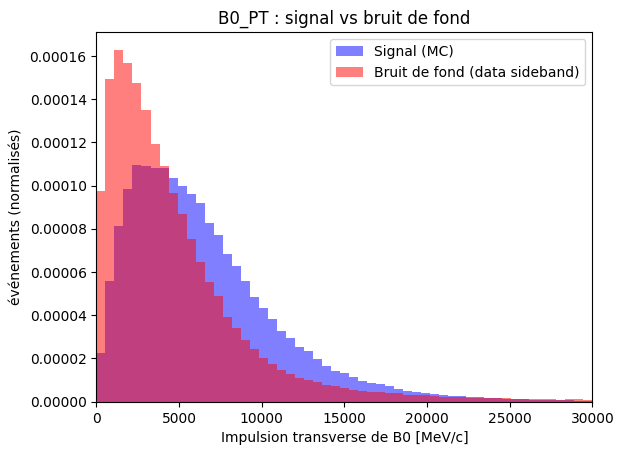

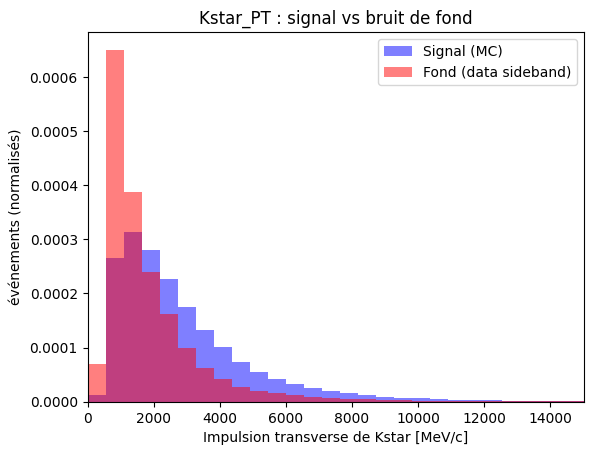

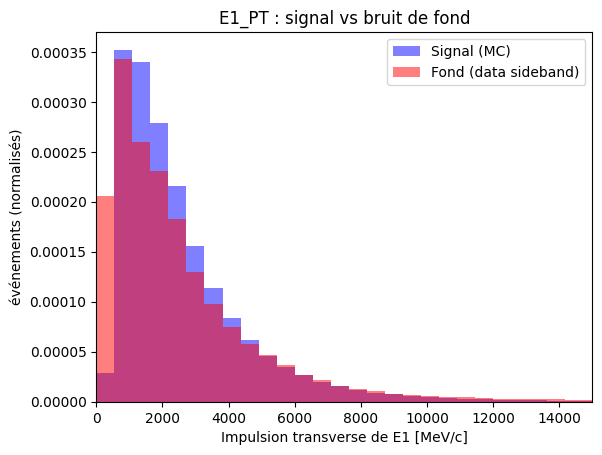

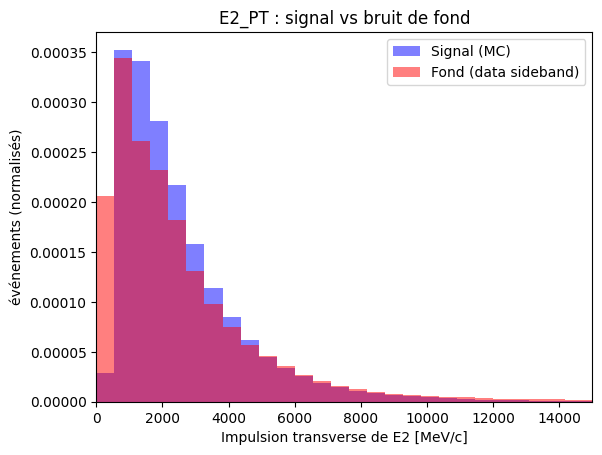

In [4]:

# Tracer un histogramme avec Matplotlib
bins = np.linspace(0, 60000, 111)  

plt.hist(ak.to_numpy(mc_bpt), bins=bins, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(ak.to_numpy(background_bpt), bins=bins, density=True, alpha=0.5, label="Bruit de fond (data sideband)", color="red")

plt.xlabel("Impulsion transverse de B0 [MeV/c]")
plt.ylabel("événements (normalisés)")
plt.legend()
plt.xlim(0, 30000)
plt.title("B0_PT : signal vs bruit de fond")
plt.show()

plt.hist(ak.to_numpy(mc_kpt), bins=bins, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(ak.to_numpy(background_kpt), bins=bins, density=True, alpha=0.5, label="Fond (data sideband)", color="red")

plt.xlabel("Impulsion transverse de Kstar [MeV/c]")
plt.ylabel("événements (normalisés)")
plt.legend()
plt.xlim(0, 15000)
plt.title("Kstar_PT : signal vs bruit de fond")
plt.show()

plt.hist(ak.to_numpy(mc_e1pt), bins=bins, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(ak.to_numpy(background_e1pt), bins=bins, density=True, alpha=0.5, label="Fond (data sideband)", color="red")

plt.xlabel("Impulsion transverse de E1 [MeV/c]")
plt.ylabel("événements (normalisés)")
plt.legend()
plt.xlim(0, 15000)
plt.title("E1_PT : signal vs bruit de fond")
plt.show()

plt.hist(ak.to_numpy(mc_e2pt), bins=bins, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(ak.to_numpy(background_e2pt), bins=bins, density=True, alpha=0.5, label="Fond (data sideband)", color="red")

plt.xlabel("Impulsion transverse de E2 [MeV/c]")
plt.ylabel("événements (normalisés)")
plt.legend()
plt.xlim(0, 15000)
plt.title("E2_PT : signal vs bruit de fond")
plt.show()

In [5]:

def plot_roc_awkward(discriminant, signal_maskb, thresholds):
    # Conversion en awkward array au cas où
    discriminant = ak.Array(discriminant)
    signal_maskb = ak.Array(signal_maskb)

    # Assurer la même taille
    min_len = min(len(discriminant), len(signal_maskb))
    discriminant = discriminant[:min_len]
    signal_maskb = signal_maskb[:min_len]

    # Séparer signal et fond
    sig_values = discriminant[signal_maskb]
    bkg_values = discriminant[~signal_maskb]

    signal_eff = []
    background_rej = []

    for t in thresholds:
        eff_sig = ak.sum(sig_values > t) / len(sig_values)
        eff_bkg = ak.sum(bkg_values > t) / len(bkg_values)
        rej_bkg = 1 - eff_bkg

        signal_eff.append(eff_sig)
        background_rej.append(rej_bkg)

    plt.plot(signal_eff, background_rej, color='black')
    plt.xlabel("Signal efficiency", fontsize=12, weight='bold')
    plt.ylabel("Background rejection", fontsize=12, weight='bold')
    plt.grid(True)
    plt.ylim(0.2, 1.01)
    plt.xlim(0, 1.01)
    plt.show()




In [6]:

# Fusionner les valeurs
all_ptsb = ak.concatenate([mc_bpt, background_bpt])
all_ptsk = ak.concatenate([mc_kpt, background_kpt])
all_ptse1 = ak.concatenate([mc_e1pt, background_e1pt])
all_ptse2 = ak.concatenate([mc_e2pt, background_e2pt])

# Créer le masque : True = signal, False = fond
signal_maskb = ak.concatenate([
    ak.Array([True] * len(mc_bpt)),
    ak.Array([False] * len(background_bpt))
])
signal_maskk = ak.concatenate([
    ak.Array([True] * len(mc_kpt)),
    ak.Array([False] * len(background_kpt))
])
signal_maske1 = ak.concatenate([
    ak.Array([True] * len(mc_e1pt)),
    ak.Array([False] * len(background_e1pt))
])
signal_maske2 = ak.concatenate([
    ak.Array([True] * len(mc_e2pt)),
    ak.Array([False] * len(background_e2pt))
])

thresholds = np.linspace(0, 20000, 200)



In [7]:


def calculer_eff_rejet(signal_maskb, cut_mask, verbose=True):
    """
    Calcule l'efficacité du signal et le rejet du fond, en pourcentages.

    Args:
        signal_maskb (ak.Array): True pour le signal, False pour le fond
        cut_mask (ak.Array): True pour les événements qui passent les cuts
        verbose (bool): Affiche les résultats

    Returns:
        Tuple: (efficacité_signal_en_%, rejet_fond_en_%)
    """
    min_len = min(len(signal_maskb), len(cut_mask))
    signal_maskb = signal_maskb[:min_len]
    cut_mask = cut_mask[:min_len]

    # Signal
    n_sig_total = ak.sum(signal_maskb)
    n_sig_pass = ak.sum(signal_maskb & cut_mask)
    eff_signal = (n_sig_pass / n_sig_total * 100) if n_sig_total > 0 else 0

    # Fond
    fond_mask = ~signal_maskb
    n_fond_total = ak.sum(fond_mask)
    n_fond_pass = ak.sum(fond_mask & cut_mask)
    rej_fond = (1 - (n_fond_pass / n_fond_total)) * 100 if n_fond_total > 0 else 0

    if verbose:
        print(f"✅ Efficacité du signal : {eff_signal:.2f}%")
        print(f"❌ Rejet du fond       : {rej_fond:.2f}%")

    return round(eff_signal, 2), round(rej_fond, 2), print(eff_signal+rej_fond)



In [ ]:

def apply_presel(tree):

    """
    Applique une présélection standard sur un arbre uproot (data ou MC).
    Ignore automatiquement les branches manquantes.
    
    Args:
        tree (uproot.tree): arbre contenant les données
    
    Returns:
        ak.Array[bool]: masque booléen de présélection
    """
    def safe_mask(tree, name, ref_key="GenericPresel"):
        if name in tree.keys():
            try:
                return tree[name].array() == 1
            except Exception as e:
                print(f"⚠️ Problème avec {name} : {e}")
                return ak.Array([True] * len(tree[ref_key].array()))
        else:
            print(f"ℹ️ '{name}' non trouvé dans le fichier, ignoré.")
            return ak.Array([True] * len(tree[ref_key].array()))

    # Liste des conditions booléennes à appliquer
    mask = (
        safe_mask(tree, "GenericPresel") &
        safe_mask(tree, "GenericPresel_Additional") &
        safe_mask(tree, "MeerkatPresel_Tight") &
        safe_mask(tree, "PIDPresel") &
        safe_mask(tree, "TighterKst0Presel") &
        safe_mask(tree, "TriggerPresel") &
        safe_mask(tree, "VetoesPresel") &
        safe_mask(tree, "CloneVeto")
    )

    return mask

presel_mc = apply_presel(tmc)
presel_data = apply_presel(td)
presel_mask = ak.concatenate([presel_mc, presel_data])

signal_maskb = ak.concatenate([
    ak.Array([True] * len(mc_bpt)),
    ak.Array([False] * len(data_bpt))
])
signal_maskk = ak.concatenate([
    ak.Array([True] * len(mc_kpt)),
    ak.Array([False] * len(data_kpt))
])
signal_maske1 = ak.concatenate([
    ak.Array([True] * len(mc_e1pt)),
    ak.Array([False] * len(data_e2pt))
])
signal_maske2 = ak.concatenate([
    ak.Array([True] * len(mc_e2pt)),
    ak.Array([False] * len(data_e2pt))
])
signal_maskm = ak.concatenate([
    ak.Array([True] * len(mc_mass)),
    ak.Array([False] * len(data_mass))
])

mc_bpt_presel = mc_bpt[presel_mc]
data_bpt_presel = data_bpt[presel_data]

mc_kpt_presel = mc_kpt[presel_mc]
data_kpt_presel = data_kpt[presel_data]

mc_e1pt_presel = mc_e1pt[presel_mc]
data_e1pt_presel = data_e1pt[presel_data]

mc_e2pt_presel = mc_e2pt[presel_mc]
data_e2pt_presel = data_e2pt[presel_data]

data_mass_presel = data_mass[presel_data]
mc_mass_presel = mc_mass[presel_mc]

# Concatenation des b_pt filtrés
b_pt_presel = ak.concatenate([mc_bpt_presel, data_bpt_presel])
k_pt_presel = ak.concatenate([mc_kpt_presel, data_kpt_presel])
e1_pt_presel = ak.concatenate([mc_e1pt_presel, data_e1pt_presel])
e2_pt_presel = ak.concatenate([mc_e2pt_presel, data_e2pt_presel])



# Construire le signal_mask synchronisé
signal_mask_preselb = ak.concatenate([
    ak.Array([True] * len(mc_bpt_presel)),
    ak.Array([False] * len(data_bpt_presel))
])
signal_mask_preselk = ak.concatenate([
    ak.Array([True] * len(mc_kpt_presel)),
    ak.Array([False] * len(data_kpt_presel))
])
signal_mask_presele1 = ak.concatenate([
    ak.Array([True] * len(mc_e1pt_presel)),
    ak.Array([False] * len(data_e1pt_presel))
])
signal_mask_presele2 = ak.concatenate([
    ak.Array([True] * len(mc_e2pt_presel)),
    ak.Array([False] * len(data_e2pt_presel))
])
signal_mask_preselm = ak.concatenate([
    ak.Array([True] * len(mc_mass_presel)),
    ak.Array([False] * len(data_mass_presel))
])

#############################################################


presel_mask = apply_presel(td)


b_pt   = data_bpt[presel_mask]
kst_pt = data_kpt[presel_mask]
e1_pt  = data_e1pt[presel_mask]
e2_pt  = data_e2pt[presel_mask]
mass   = data_mass[presel_mask]




In [18]:

cut_maskb = b_pt_presel > 1000
cut_maskk = k_pt_presel > 2700 
cut_maske1 = e1_pt_presel > 900
cut_maske2 = e2_pt_presel > 900

cut_total = (
    cut_maskb &
    cut_maskk &
    cut_maske1 &
    cut_maske2
)


# 1. Sélectionner les événements de data uniquement

mass_total = ak.concatenate([mc_mass_presel, data_mass_presel])
mass_data_only = mass_total[~signal_mask_preselm]

# 2. Sélectionner le masque de cut appliqué uniquement aux données
cut_data_only = cut_total[~signal_mask_preselm]

# 3. Appliquer le cut à la data
mass_data_cut = mass_data_only[cut_data_only]

mass_data_only = mass_total[~signal_mask_preselm]
cut_data_only = cut_total[~signal_mask_preselm]
data_mass_presel_cut = mass_data_only[cut_data_only]

#print(f"Événements data avant cut : {len(mass_data_only)}")
#print(f"Événements data après cut : {len(mass_data_cut)}")


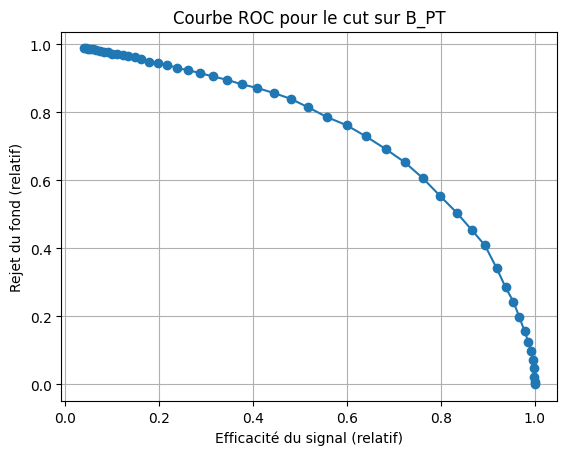

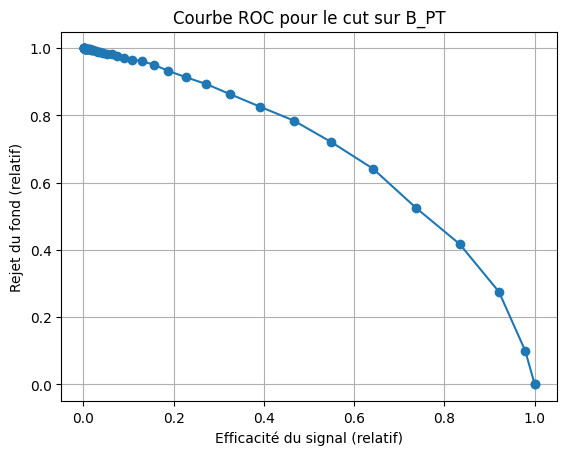

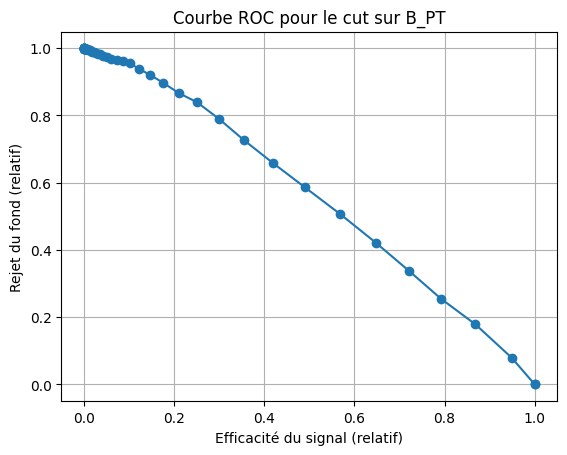

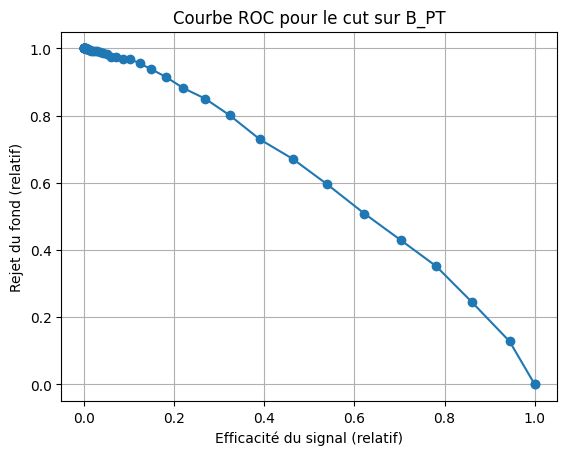

In [10]:


def tracer_roc(discriminant, signal_mask, mass_total, seuils, fond_seuil=5600):
    effs = []
    rejs = []

    for seuil in seuils:
        cut_mask = discriminant > seuil

        # Efficacité relative (signal)
        n_signal_tot = ak.sum(signal_mask)
        n_signal_pass = ak.sum(signal_mask & cut_mask)
        eff = n_signal_pass / n_signal_tot if n_signal_tot > 0 else 0

        # Rejet relatif (fond)
        fond_mask = (mass_total > fond_seuil) & ~signal_mask
        n_fond_tot = ak.sum(fond_mask)
        n_fond_pass = ak.sum(fond_mask & cut_mask)
        rej = 1 - (n_fond_pass / n_fond_tot) if n_fond_tot > 0 else 0

        effs.append(eff)
        rejs.append(rej)

    # Tracer la ROC
    plt.plot(effs, rejs, marker='o')
    plt.xlabel("Efficacité du signal (relatif)")
    plt.ylabel("Rejet du fond (relatif)")
    plt.title("Courbe ROC pour le cut sur B_PT")
    plt.grid(True)
    plt.show()
seuils = np.linspace(0, 20000, 50)  # valeurs de B_PT à tester
tracer_roc(b_pt_presel, signal_mask_preselb, mass_total, seuils)
tracer_roc(k_pt_presel, signal_mask_preselk, mass_total, seuils)
tracer_roc(e1_pt_presel, signal_mask_presele1, mass_total, seuils)
tracer_roc(e2_pt_presel, signal_mask_presele2, mass_total, seuils)

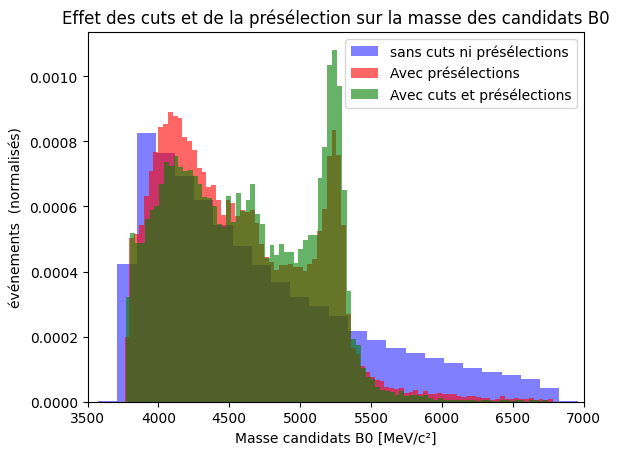

In [11]:


plt.hist(data_mass, bins=100, density=True, alpha=0.5, label="sans cuts ni présélections", color="blue")
plt.hist(data_mass_presel, bins=100, density=True, alpha=0.6, label="Avec présélections", color="red")
plt.hist(data_mass_presel_cut, bins=100, density=True, alpha=0.6, label="Avec cuts et présélections", color="green")
plt.xlabel("Masse candidats B0 [MeV/c²]")
plt.ylabel("événements  (normalisés)")
plt.title("Effet des cuts et de la présélection sur la masse des candidats B0")
plt.legend()
plt.xlim(3500,7000)
plt.show()

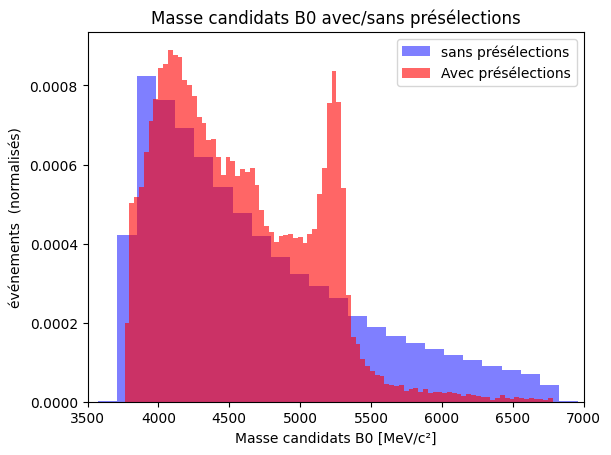

In [19]:
plt.hist(data_mass, bins=100, density=True, alpha=0.5, label="sans présélections", color="blue")
plt.hist(data_mass_presel, bins=100, density=True, alpha=0.6, label="Avec présélections", color="red")
plt.xlabel("Masse candidats B0 [MeV/c²]")
plt.ylabel("événements  (normalisés)")
plt.title("Masse candidats B0 avec/sans présélections")
plt.legend()
plt.xlim(3500,7000)
plt.show()

In [20]:
n_mc_total   = len(mc_mass)
n_mc_pass    = ak.sum(presel_mc)

eff_presel = n_mc_pass / n_mc_total * 100
print(f"✅ Efficacité de la présélection (signal MC) : {eff_presel:.2f}%")

n_data_total = ak.sum(background_mask)
n_data_pass  = ak.sum(background_mask & presel_data)

rej_presel = (1 - n_data_pass / n_data_total) * 100
print(f"❌ Rejet de la présélection (fond) : {rej_presel:.2f}%") # seulement la présélection


✅ Efficacité de la présélection (signal MC) : 12.56%
❌ Rejet de la présélection (fond) : 99.71%


In [14]:
def efficacité_rejet_relative_fusionnée(signal_mask_presel, cut_mask, mass_total, background_mass_threshold=5600):
    """
    Calcule l'efficacité relative du signal et le rejet relatif du fond
    à partir d'un tableau fusionné MC + data après présélection.

    Arguments :
    - signal_mask_presel : booléen (True pour MC, False pour data), même taille que mass_total
    - cut_mask           : booléen indiquant quels événements passent les cuts
    - mass_total         : tableau de masse (MC + data), même taille que signal_mask
    - background_mass_threshold : seuil pour définir le fond (ex: B_M > 5600)

    Retourne :
    - efficacité relative (%), rejet relatif (%)
    """

    # ---- MC (signal) ----
    n_mc_presel = ak.sum(signal_mask_presel)
    n_mc_pass = ak.sum(signal_mask_presel & cut_mask)
    eff_relative = n_mc_pass / n_mc_presel * 100 if n_mc_presel > 0 else 0

    # ---- Fond (data) dans sideband ----
    background_mask = (mass_total > background_mass_threshold) & ~signal_mask_presel
    n_bkg_presel = ak.sum(background_mask)
    n_bkg_pass = ak.sum(background_mask & cut_mask)
    rej_relative = (1 - n_bkg_pass / n_bkg_presel) * 100 if n_bkg_presel > 0 else 0

    print(f"✅ Efficacité relative du signal : {eff_relative:.2f}%")
    print(f"❌ Rejet relatif du fond        : {rej_relative:.2f}%")

    return eff_relative, rej_relative

efficacité_rejet_relative_fusionnée(signal_mask_preselm,cut_total,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_preselb,cut_maskb,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_preselk,cut_maskk,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_presele1,cut_maske1,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_presele2,cut_maske2,mass_total)


✅ Efficacité relative du signal : 49.55%
❌ Rejet relatif du fond        : 80.31%

✅ Efficacité relative du signal : 99.87%
❌ Rejet relatif du fond        : 3.01%

✅ Efficacité relative du signal : 58.56%
❌ Rejet relatif du fond        : 69.74%

✅ Efficacité relative du signal : 93.25%
❌ Rejet relatif du fond        : 9.51%

✅ Efficacité relative du signal : 92.80%
❌ Rejet relatif du fond        : 14.84%


(np.float64(92.79615187567597), np.float64(14.839961202715813))

=== Paramètres du fit (non pondéré) ===
A_sig        =   39.0937 ± 25.1104
mu [MeV]     = 5240.4682 ± 10.0293
sigma [MeV]  =   50.0000 ± 18.1420
A_bkg        = 1404.2407 ± 1135124.0542
a [1/MeV]    =    0.0009 ± 0.1959
b            =    0.0000 ± 2667.9027

=== Comptes estimés dans la fenêtre ===
Nsig   (somme bins) = 1732.8
Nfond  (somme bins) = 952.2
Fraction signal     = 0.645

=== Qualité du fit ===
RMSE (comptes/bin)  = 5.442
R^2                 = 0.868
chi2/ndf            = 0.923  (≈1 attendu si bon modèle et bruit Poisson)


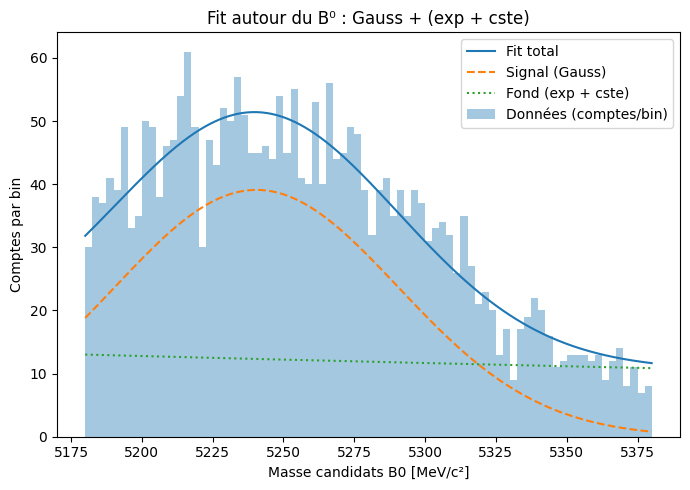

In [ ]:


xmin, xmax = 5180.0, 5380.0   # Fenêtre autour du pic B0 (MeV)
nbins = 80                    # Nombre de bins (≈ 2.5 MeV/bin ici)


masses = np.asarray(data_mass_presel_cut, dtype=float).ravel()


mask = (masses >= xmin) & (masses <= xmax)
data_win = masses[mask]
counts, edges = np.histogram(data_win, bins=nbins, range=(xmin, xmax))
x = 0.5*(edges[1:] + edges[:-1])        # centres de bins -> variable indépendante
y = counts.astype(float)                # comptes par bin -> variable dépendante
bin_width = (edges[1] - edges[0])


def model(x, A_sig, mu, sigma, A_bkg, a, b):
    gauss = A_sig * np.exp(-(x - mu)**2 / (2.0 * sigma**2))
    bkg   = A_bkg * np.exp(-a * x) + b
    return gauss + bkg


A0 = max(y.max(), 1.0)
mu0 = 5280.0
sigma0 = max((xmax - xmin)/100.0, 1.0)
Ab0 = 0.5*A0
a0 = 0.001
b0 = np.percentile(y[y>0], 10) if np.any(y>0) else 0.0
p0 = [A0, mu0, sigma0, Ab0, a0, b0]

bounds = (
    [0.0, xmin, 0.5,   0.0, 0.0, 0.0],   
    [np.inf, xmax, 50.0, np.inf, 0.01, np.inf] 
)


popt, pcov = curve_fit(model, x, y, p0=p0, bounds=bounds, maxfev=20000)
A_sig, mu, sigma, A_bkg, a, b = popt
perr = np.sqrt(np.diag(pcov))  


y_sig  = A_sig * np.exp(-(x - mu)**2 / (2.0 * sigma**2))
y_fond = A_bkg * np.exp(-a * x) + b
Nsig   = float(np.sum(y_sig))
Nfond  = float(np.sum(y_fond))
frac_sig = Nsig / (Nsig + Nfond) if (Nsig + Nfond) > 0 else np.nan


yfit = model(x, *popt)
res  = y - yfit
SSR  = float(np.sum(res**2))
SST  = float(np.sum((y - np.mean(y))**2)) if np.any(y != y.mean()) else np.nan
RMSE = float(np.sqrt(SSR / y.size))
R2   = float(1.0 - SSR/SST) if np.isfinite(SST) and SST>0 else np.nan

eps  = 1e-9
chi2 = float(np.sum((res**2) / (yfit + eps)))
ndf  = int(y.size - len(popt))
red_chi2 = float(chi2 / max(ndf,1))


print("=== Paramètres du fit (non pondéré) ===")
labels = ["A_sig", "mu [MeV]", "sigma [MeV]", "A_bkg", "a [1/MeV]", "b"]
for lab, val, err in zip(labels, popt, perr):
    print(f"{lab:12s} = {val:9.4f} ± {err:.4f}")
print("\n=== Comptes estimés dans la fenêtre ===")
print(f"Nsig   (somme bins) = {Nsig:.1f}")
print(f"Nfond  (somme bins) = {Nfond:.1f}")
print(f"Fraction signal     = {frac_sig:.3f}")
print("\n=== Qualité du fit ===")
print(f"RMSE (comptes/bin)  = {RMSE:.3f}")
print(f"R^2                 = {R2:.3f}")
print(f"chi2/ndf            = {red_chi2:.3f}  (≈1 attendu si bon modèle et bruit Poisson)")


plt.figure(figsize=(7,5))
plt.bar(x, y, width=bin_width, alpha=0.4, label="Données (comptes/bin)")
xplot = np.linspace(xmin, xmax, 600)
plt.plot(xplot, model(xplot, *popt), label="Fit total")
plt.plot(xplot, A_sig * np.exp(-(xplot - mu)**2 / (2.0 * sigma**2)), linestyle="--", label="Signal (Gauss)")
plt.plot(xplot, A_bkg * np.exp(-a * xplot) + b, linestyle=":", label="Fond (exp + cste)")
plt.xlabel("Masse candidats B0 [MeV/c²]")
plt.ylabel("Comptes par bin")
plt.title("Fit autour du B⁰ : Gauss + (exp + cste)")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# MÉTHODE B : PDFs normalisées dans la fenêtre, rendements directs Nsig/Nfond
from scipy.special import erf



xmin, xmax = 5180.0, 5380.0   
nbins = 80                    


masses = np.asarray(data_mass_presel_cut, dtype=float).ravel()
mask = (masses >= xmin) & (masses <= xmax)
data_win = masses[mask]

y, edges = np.histogram(data_win, bins=nbins, range=(xmin, xmax))
x = 0.5*(edges[1:] + edges[:-1])           
y = y.astype(float)                        
dx = float(edges[1] - edges[0])            


def Phi(z):  # CDF normale standard
    return 0.5*(1.0 + erf(z/np.sqrt(2.0)))

def G_window_norm(x, mu, sigma, xmin, xmax):
    """Gauss tronquée et normalisée sur [xmin, xmax]."""
    sigma = np.abs(sigma)
    z = (x - mu)/sigma
    phi = (1.0/(sigma*np.sqrt(2.0*np.pi))) * np.exp(-0.5*z*z)   # densité "pleine ligne"
    c = Phi((xmax - mu)/sigma) - Phi((xmin - mu)/sigma)         # fraction contenue dans la fenêtre
    c = np.maximum(c, 1e-12)                                    # éviter division par ~0
    return phi / c                                              # ∫_xmin^xmax G = 1

def B_window_norm(x, a, beta, xmin, xmax):
    """Fond ~ exp(-a x) + beta, normalisé sur [xmin, xmax]. beta >= 0."""
    a = np.abs(a)
    beta = np.maximum(beta, 0.0)
    num = np.exp(-a*x) + beta
    # constante de normalisation Z = ∫ (exp(-a x) + beta) dx sur la fenêtre
    if a < 1e-12:
        Z = (1.0 + beta) * (xmax - xmin)
    else:
        Z = (np.exp(-a*xmin) - np.exp(-a*xmax))/a + beta*(xmax - xmin)
    Z = np.maximum(Z, 1e-12)
    return num / Z                                              # ∫_xmin^xmax B = 1


def model_counts(x_centers, Nsig, mu, sigma, Nfond, a, beta, xmin, xmax, dx):
    G = G_window_norm(x_centers, mu, sigma, xmin, xmax)
    B = B_window_norm(x_centers, a, beta, xmin, xmax)
    # Attendu par bin i : λ_i = (Nsig*G + Nfond*B) * dx
    return (Nsig*G + Nfond*B) * dx

def model_for_fit(x_centers, Nsig, mu, sigma, Nfond, a, beta):
    return model_counts(x_centers, Nsig, mu, sigma, Nfond, a, beta, xmin, xmax, dx)


Ntot = float(np.sum(y))
p0 = [0.6*Ntot, 5280.0, max((xmax-xmin)/100.0, 1.0), 0.4*Ntot, 0.001, 0.2]
bounds = (
    [0.0, xmin, 0.5, 0.0, 0.0, 0.0],          
    [2*Ntot, xmax, 50.0, 2*Ntot, 0.05, 100.0]  
)

popt, pcov = curve_fit(model_for_fit, x, y, p0=p0, bounds=bounds, maxfev=20000)
perr = np.sqrt(np.diag(pcov))
Nsig, mu, sigma, Nfond, a, beta = popt


yhat = model_for_fit(x, *popt)
res  = y - yhat
SSR  = float(np.sum(res**2))
RMSE = float(np.sqrt(SSR / y.size))
eps  = 1e-9
chi2 = float(np.sum((res**2) / (yhat + eps)))   #
ndf  = int(y.size - len(popt))
red_chi2 = float(chi2 / max(ndf,1))


print("=== Méthode B (PDF normalisées) — Résultats ===")
print(f"Nsig         = {Nsig:.2f} ± {perr[0]:.2f}")
print(f"Nfond        = {Nfond:.2f} ± {perr[3]:.2f}")
print(f"mu [MeV]     = {mu:.3f} ± {perr[1]:.3f}")
print(f"sigma [MeV]  = {sigma:.3f} ± {perr[2]:.3f}")
print(f"a [1/MeV]    = {a:.5f} ± {perr[4]:.5f}")
print(f"beta         = {beta:.3f} ± {perr[5]:.3f}")
print("\n--- Qualité d'ajustement ---")
print(f"RMSE (comptes/bin) = {RMSE:.3f}")
print(f"chi2/ndf           = {red_chi2:.3f}  (≈1 attendu si bon accord)")





=== Méthode B (PDF normalisées) — Résultats ===
Nsig         = 1785.34 ± 166.68
Nfond        = 897.79 ± 174.39
mu [MeV]     = 5239.518 ± 2.073
sigma [MeV]  = 50.000 ± 3.890
a [1/MeV]    = 0.00835 ± 0.00000
beta         = 0.004 ± 0.000

--- Qualité d'ajustement ---
RMSE (comptes/bin) = 5.511
chi2/ndf           = 0.953  (≈1 attendu si bon accord)
